## Reading Data from the STAC API

The Planetary Computer catalogs the datasets we host using the [STAC](http://stacspec.org/) (SpatioTemporal Asset Catalog) specification. We provide a [STAC API](https://github.com/radiantearth/stac-api-spec) endpoint for searching our datasets by space, time, and more. This quickstart will show you how to search for data using our STAC API and open-source Python libraries. To use our STAC API from R, see [Reading data from the STAC API with R](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac-r/).

To get started you'll need the [pystac-client](https://github.com/stac-utils/pystac-client) library installed. You can install it via pip:

```
> python -m pip install pystac-client
> python -m pip install planetary_computer
> python -m pip install rioxarray
```

To access the data, we'll create a `pystac_client.Client`. We'll explain the `modifier` part later on, but it's what lets us download the data assets Azure Blob Storage.

In [4]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Searching

We can use the STAC API to search for assets meeting some criteria. This might include the date and time the asset covers, is spatial extent, or any other property captured in the STAC item's metadata.

In this example we'll search for imagery from [Landsat Collection 2 Level-2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) area around Muret (31) in June of 2021.

bbox = Ox (31)
    

In [5]:
time_range = "2024-06-01/2024-06-30"
# bbox = [-122.2751, 47.5469, -121.9613, 47.7458]
bbox = [1.283083,43.439552,1.302631,43.451268]
# bbox = Ox (31)

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, datetime=time_range)
# items = search.get_all_items()
items = search.item_collection()
len(items)

6

In that example our spatial query used a bounding box with a `bbox`. Alternatively, you can pass a GeoJSON object as `intersects`

```python
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.2751, 47.5469],
            [-121.9613, 47.9613],
            [-121.9613, 47.9613],
            [-122.2751, 47.9613],
            [-122.2751, 47.5469],
        ]
    ],
}

time_range = "2020-12-01/2020-12-31"

search = catalog.search(
    collections=["landsat-c2-l2"], intersects=area_of_interest, datetime=time_range
)
```

`items` is a [`pystac.ItemCollection`](https://pystac.readthedocs.io/en/stable/api/item_collection.html#pystac-item-collection). We can see that 4 items matched our search criteria.

In [6]:
len(items)

6

Each [`pystac.Item`](https://pystac.readthedocs.io/en/stable/api/pystac.html#pystac.Item) in this `ItemCollection` includes all the metadata for that scene. [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) are GeoJSON features, and so can be loaded by libraries like [geopandas](http://geopandas.readthedocs.io/).

In [ ]:
import geopandas

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

Some collections implement the `eo` extension, which we can use to sort the items by cloudiness. We'll grab an item with low cloudiness:

In [8]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
print(selected_item)

<Item id=LC09_L2SP_198030_20240616_02_T1>


Each STAC item has one or more [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object), which include links to the actual files.

In [9]:
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in selected_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Description                                                          ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ qa               │ Surface Temperature Quality Assessment Band                          │
│ ang              │ Angle Coefficients File                                              │
│ red              │ Red Band                                                             │
│ blue             │ Blue Band                                                            │
│ drad             │ Downwelled Radiance Band                                             │
│ emis             │ Emissivity Band                                                      │
│ emsd             │ Emissivity Standard Deviation Band                                   │
│ trad             │ Thermal Radiance Band                                                │
│ urad             │ Upwelled Radiance Band                                               │
│ atran            │ Atmospheric Transmittance Band                                       │
│ cdist            │ Cloud Distance Band                                                  │
│ green            │ Green Band                                                           │
│ nir08            │ Near Infrared Band 0.8                                               │
│ lwir11           │ Surface Temperature Band                                             │
│ swir16           │ Short-wave Infrared Band 1.6                                         │
│ swir22           │ Short-wave Infrared Band 2.2                                         │
│ coastal          │ Coastal/Aerosol Band                                                 │
│ mtl.txt          │ Product Metadata File (txt)                                          │
│ mtl.xml          │ Product Metadata File (xml)                                          │
│ mtl.json         │ Product Metadata File (json)                                         │
│ qa_pixel         │ Pixel Quality Assessment Band                                        │
│ qa_radsat        │ Radiometric Saturation and Terrain Occlusion Quality Assessment Band │
│ qa_aerosol       │ Aerosol Quality Assessment Band                                      │
│ tilejson         │ TileJSON with default rendering                                      │
│ rendered_preview │ Rendered preview                                                     │
└──────────────────┴──────────────────────────────────────────────────────────────────────┘

Here, we'll inspect the `rendered_preview` asset.

In [11]:
selected_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LC09_L2SP_198030_20240616_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55&format=png',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

In [15]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)

That `rendered_preview` asset is generated dynamically from the raw data using the Planetary Computer's [data API](http://planetarycomputer.microsoft.com/api/data/v1/). We can access the raw data, stored as Cloud Optimzied GeoTIFFs in Azure Blob Storage, using one of the other assets.

The actual data assets are in *private* [Azure Blob Storage containers](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction#containers). If forget to pass `modifier=planetary_computer.sign_inplace` or manually sign the item, then you'll get a 404 when trying to access the asset.

That's why we included the `modifier=planetary_computer.sign_inplace` when we created the `pystac_client.Client` earlier. With that, the results returned by pystac-client are automatically signed, so that a token granting access to the file is included in the URL.

Je veux sauvegarder cette image sur s3 

In [ ]:
s3 = fs.S3FileSystem(endpoint_override='https://'+'minio.lab.sspcloud.fr')
bucket = "test_stat"
path_data = "s3/bballet/test_sat/"

In [17]:
selected_item.assets["blue"].href[:250]

'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2024/198/030/LC09_L2SP_198030_20240616_20240617_02_T1/LC09_L2SP_198030_20240616_20240617_02_T1_SR_B2.TIF?st=2025-04-02T14%3A26%3A33Z&se=2025-04-03T15%3A11%3A33Z&sp=rl&sv'

 Everything after the `?` in that URL is a [SAS token](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) grants access to the data. See https://planetarycomputer.microsoft.com/docs/concepts/sas/ for more on using tokens to access data.

In [18]:
import requests

requests.head(selected_item.assets["blue"].href).status_code

200

The `200` status code indicates that we were able to successfully access the data using the "signed" URL with the SAS token included.

We can load up that single COG using libraries like [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) or [rasterio](https://rasterio.readthedocs.io/en/latest/)

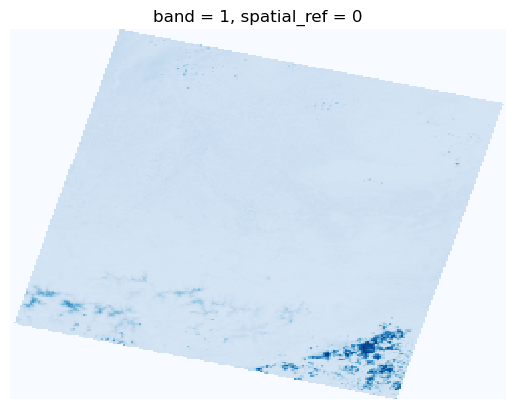

In [20]:
# import xarray as xr
import rioxarray

ds = rioxarray.open_rasterio(
    selected_item.assets["blue"].href, overview_level=4
).squeeze()
img = ds.plot(cmap="Blues", add_colorbar=False)
img.axes.set_axis_off();

If you wish to work with multiple STAC items as a datacube, you can use libraries like [stackstac](https://stackstac.readthedocs.io/) or [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html).

In [12]:
import stackstac

ds = stackstac.stack(items)
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-58124a3f2aeb9e86fe45c8d5489954e7' (time: 8,
                                                                band: 22,
                                                                y: 7972,
                                                                x: 12372)>
dask.array<fetch_raster_window, shape=(8, 22, 7972, 12372), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2020-12-04T19:02:11.19...
    id                           (time) <U31 'LC08_L2SP_047027_20201204_02_T1...
  * band                         (band) <U13 'qa' 'red' ... 'atmos_opacity'
  * x                            (x) float64 3.339e+05 3.339e+05 ... 7.05e+05
  * y                            (y) float64 5.374e+06 5.374e+06 ... 5.135e+06
    landsat:wrs_type             <U1 '2'
    ...                           ...
    title                        (band) object 'Surface Temperature Quality A...
    classification:bitfields     (band) object None None ... None
    common_name                  (band) object None None None ... None None
    center_wavelength            (band) object None None None ... None None
    full_width_half_max          (band) object None None None ... 2.05 None None
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(333870.0, 5135070.0, 705030.0...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 333870.00|\n| 0.00,-30.00, 5374230.00|\n| 0.0...
    resolution:  30.0

### Searching on additional properties

Previously, we searched for items by space and time. Because the Planetary Computer's STAC API supports the [query](https://github.com/radiantearth/stac-api-spec/blob/master/fragments/query/README.md) parameter, you can search on additional properties on the STAC item.

For example, collections like `sentinel-2-l2a` and `landsat-c2-l2` both implement the [`eo` STAC extension](https://github.com/stac-extensions/eo) and include an `eo:cloud_cover` property. Use `query={"eo:cloud_cover": {"lt": 20}}` to return only items that are less than 20% cloudy.

In [13]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
)
items = search.get_all_items()

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:841: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Other common uses of the `query` parameter is to filter a collection down to items of a specific type, For example, the [GOES-CMI](https://planetarycomputer.microsoft.com/dataset/goes-cmi) collection includes images from various when the satellite is in various modes, which produces images of either the Full Disk of the earth, the continental United States, or a mesoscale. You can use `goes:image-type` to filter down to just the ones you want.

In [14]:
search = catalog.search(
    collections=["goes-cmi"],
    bbox=[-67.2729, 25.6000, -61.7999, 27.5423],
    datetime=["2018-09-11T13:00:00Z", "2018-09-11T15:40:00Z"],
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)

### Analyzing STAC Metadata

STAC items are proper GeoJSON Features, and so can be treated as a kind of data on their own.

In [15]:
import contextily

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -110.9613, 47.7458],
    datetime="2020-12-26/2020-12-31",
)
items = search.item_collection()

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

ax = df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].plot(
    facecolor="none", figsize=(12, 6)
)
contextily.add_basemap(
    ax, crs=df.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap
);

<Figure size 1200x600 with 1 Axes>

Or we can plot cloudiness of a region over time.

In [16]:
import pandas as pd

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -123.9613, 45.7458],
    datetime="2020-01-01/2020-12-31",
)
items = search.get_all_items()
df = geopandas.GeoDataFrame.from_features(items.to_dict())
df["datetime"] = pd.to_datetime(df["datetime"])

ts = df.set_index("datetime").sort_index()["eo:cloud_cover"].rolling(7).mean()
ts.plot(title="eo:cloud-cover (7-scene rolling average)");

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:841: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


<Figure size 640x480 with 1 Axes>

### Working with STAC Catalogs and Collections

Our `catalog` is a [STAC Catalog](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) that we can crawl or search. The Catalog contains [STAC Collections](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) for each dataset we have indexed (which is not the yet the entirety of data hosted by the Planetary Computer).

Collections have information about the [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) they contain. For instance, here we look at the [Bands](https://github.com/stac-extensions/eo#band-object) available for [Landsat 8 Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data:

In [17]:
import pandas as pd

landsat = catalog.get_collection("landsat-c2-l2")

pd.DataFrame(landsat.summaries.get_list("eo:bands"))

,name,common_name,description,center_wavelength,full_width_half_max
0,TM_B1,blue,Visible blue (Thematic Mapper),0.49,0.07
1,TM_B2,green,Visible green (Thematic Mapper),0.56,0.08
2,TM_B3,red,Visible red (Thematic Mapper),0.66,0.06
3,TM_B4,nir08,Near infrared (Thematic Mapper),0.83,0.14
4,TM_B5,swir16,Short-wave infrared (Thematic Mapper),1.65,0.20
5,TM_B6,lwir,Long-wave infrared (Thematic Mapper),11.45,2.10
6,TM_B7,swir22,Short-wave infrared (Thematic Mapper),2.22,0.27
7,ETM_B1,blue,Visible blue (Enhanced Thematic Mapper Plus),0.48,0.07
8,ETM_B2,green,Visible green (Enhanced Thematic Mapper Plus),0.56,0.08
9,ETM_B3,red,Visible red (Enhanced Thematic Mapper Plus),0.66,0.06


We can see what [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) are available on our item with:

In [18]:
pd.DataFrame.from_dict(landsat.extra_fields["item_assets"], orient="index")[
    ["title", "description", "gsd"]
]

,title,description,gsd
qa,Surface Temperature Quality Assessment Band,Collection 2 Level-2 Quality Assessment Band (...,NaN
ang,Angle Coefficients File,Collection 2 Level-1 Angle Coefficients File,NaN
red,Red Band,NaN,NaN
blue,Blue Band,NaN,NaN
drad,Downwelled Radiance Band,Collection 2 Level-2 Downwelled Radiance Band ...,NaN
emis,Emissivity Band,Collection 2 Level-2 Emissivity Band (ST_EMIS)...,NaN
emsd,Emissivity Standard Deviation Band,Collection 2 Level-2 Emissivity Standard Devia...,NaN
lwir,Surface Temperature Band,Collection 2 Level-2 Thermal Infrared Band (ST...,NaN
trad,Thermal Radiance Band,Collection 2 Level-2 Thermal Radiance Band (ST...,NaN
urad,Upwelled Radiance Band,Collection 2 Level-2 Upwelled Radiance Band (S...,NaN


Some collections, like [Daymet](https://planetarycomputer.microsoft.com/dataset/daymet-daily-na) include collection-level assets. You can use the `.assets` property to access those assets.

In [19]:
collection = catalog.get_collection("daymet-daily-na")
print(collection)

<CollectionClient id=daymet-daily-na>


Just like assets on items, these assets include links to data in Azure Blob Storage.

In [20]:
asset = collection.assets["zarr-abfs"]
print(asset)

<Asset href=abfs://daymet-zarr/daily/na.zarr>


In [21]:
import xarray as xr

ds = xr.open_zarr(
    asset.href,
    **asset.extra_fields["xarray:open_kwargs"],
    storage_options=asset.extra_fields["xarray:storage_options"],
)
ds

<xarray.Dataset>
Dimensions:                  (time: 14965, y: 8075, x: 7814, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

### Manually signing assets

Earlier on, when we created our `pystac_client.Client`, we specified `modifier=planetary_computer.sign_inplace`. That `modifier` will automatically "sign" the STAC metadata, so that the assets can be accessed.

Alternatively, you can manually sign the items.

In [22]:
import pystac

item = pystac.read_file(selected_item.get_self_href())
signed_item = planetary_computer.sign(item)  # these assets can be accessed
requests.head(signed_item.assets["blue"].href).status_code

200

Internally, that `planetary_computer.sign` method is making a request to the Planetary Computer's [SAS API](http://planetarycomputer.microsoft.com/api/sas/v1/docs) to get a signed HREF for each asset. You could do that manually yourself.

In [23]:
collection = item.get_collection()
storage_account = collection.extra_fields["msft:storage_account"]
container = collection.extra_fields["msft:container"]

response = requests.get(
    f"https://planetarycomputer.microsoft.com/api/sas/v1/token/{collection.id}"
)

signed_url = item.assets["blue"].href + "?" + response.json()["token"]

requests.head(signed_url).status_code

200

See https://planetarycomputer.microsoft.com/docs/concepts/sas/ for more on how to manually sign assets.